<a href="https://colab.research.google.com/github/bilal-najar/AAI-521/blob/main/Assignment3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Assignment 3 Exercise: Object Detection and Segmentation - Bilal Najar

# Part 1: Object Segmentation

In [5]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pylab as plt
import numpy as np
import cv2

In [6]:
!pip install kagglehub

In [28]:
import kagglehub
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil

# Download the dataset
path = kagglehub.dataset_download("devdgohil/the-oxfordiiit-pet-dataset")
print("Path to dataset files:", path)

# Define target path in /content
target_path = "/content/oxfordiiit-pet-dataset"

# Move the downloaded dataset to /content
if not os.path.exists(target_path):
    shutil.move(path, target_path)
    print(f"Dataset moved to {target_path}")
else:
    print(f"Dataset already exists at {target_path}")


100%|██████████| 780M/780M [00:37<00:00, 21.7MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/devdgohil/the-oxfordiiit-pet-dataset/versions/2
Dataset already exists at /content/oxfordiiit-pet-dataset


Found 7390 images and 14780 masks.
Filtered mask paths, valid masks found: 7390


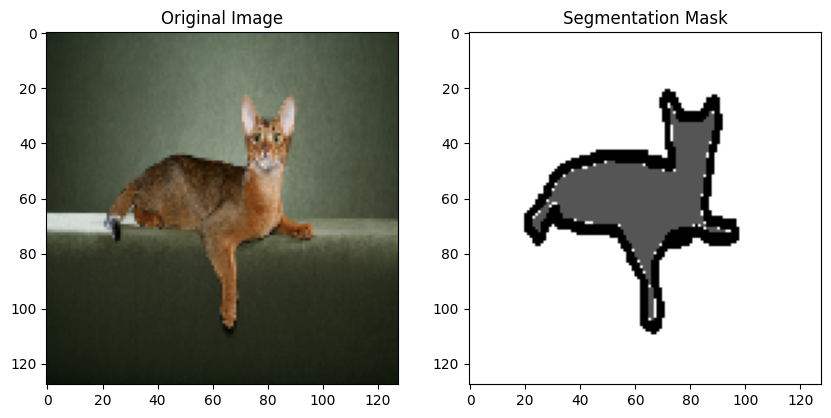

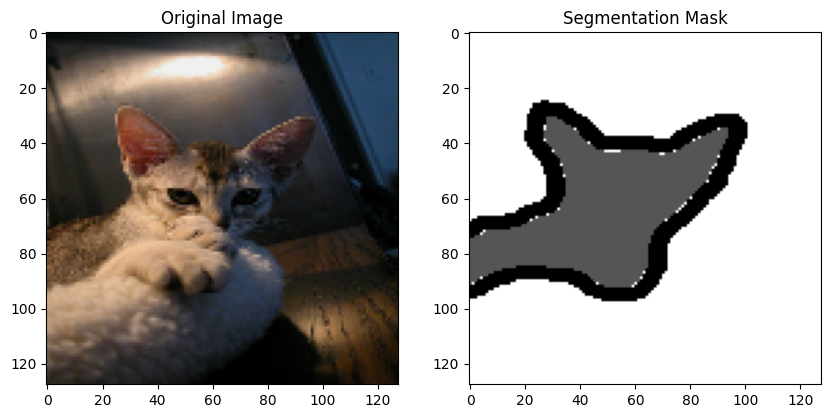

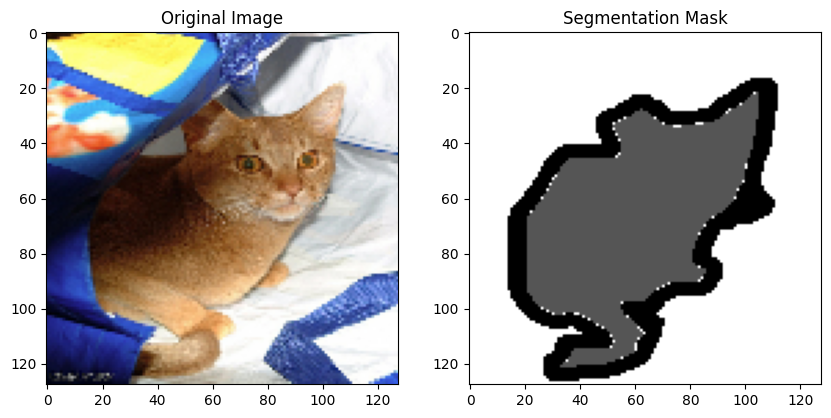

In [29]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os

# Define paths for images and masks
image_dir = "/content/oxfordiiit-pet-dataset/images/images"
mask_dir = "/content/oxfordiiit-pet-dataset/annotations/annotations/trimaps"

# Separate files into images and masks based on file extensions
image_paths = sorted([os.path.join(image_dir, fname) for fname in os.listdir(image_dir) if fname.endswith(".jpg")])
mask_paths = sorted([os.path.join(mask_dir, fname) for fname in os.listdir(mask_dir) if fname.endswith(".png")])

print(f"Found {len(image_paths)} images and {len(mask_paths)} masks.")

# Filter out any non-PNG files in mask_paths
def is_valid_image(file_path):
    try:
        img = tf.io.read_file(file_path)
        _ = tf.image.decode_png(img, channels=1)
        return True
    except:
        return False

mask_paths = [path for path in mask_paths if is_valid_image(path)]
print(f"Filtered mask paths, valid masks found: {len(mask_paths)}")

# Check if files were found and proceed to display
if len(image_paths) > 0 and len(mask_paths) > 0:
    # Define a function to preprocess images and masks
    def preprocess_image(image_path, mask_path):
        image = tf.io.read_file(image_path)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, (128, 128))
        image = tf.cast(image, tf.float32) / 255.0

        mask = tf.io.read_file(mask_path)
        mask = tf.image.decode_png(mask, channels=1)
        mask = tf.image.resize(mask, (128, 128))
        mask = tf.cast(mask, tf.int32)

        # Adjust mask values for visualization
        mask = tf.where(mask == 1, 128, mask)   # Background
        mask = tf.where(mask == 2, 255, mask)   # Foreground
        mask = tf.where(mask == 3, 64, mask)    # Boundary

        return image, mask

    # Function to display a few images and their masks
    def display_sample_images(image_paths, mask_paths, num_samples=3):
        for i in range(min(num_samples, len(image_paths), len(mask_paths))):
            image, mask = preprocess_image(image_paths[i], mask_paths[i])

            plt.figure(figsize=(10, 5))
            plt.subplot(1, 2, 1)
            plt.imshow(image)
            plt.title("Original Image")
            plt.subplot(1, 2, 2)
            plt.imshow(mask, cmap='gray')
            plt.title("Segmentation Mask")
            plt.show()

    # Display images and masks
    display_sample_images(image_paths, mask_paths)
else:
    print("No images or masks found. Please verify the dataset structure.")

# Part 2: Annotation

In [30]:
!git clone https://github.com/experiencor/raccoon_dataset.git /content/raccoon_dataset

Cloning into '/content/raccoon_dataset'...
remote: Enumerating objects: 646, done.
remote: Counting objects: 100% (646/646), done.
remote: Compressing objects: 100% (232/232), done.
remote: Total 646 (delta 413), reused 643 (delta 412), pack-reused 0 (from 0)
Receiving objects: 100% (646/646), 48.00 MiB | 12.08 MiB/s, done.
Resolving deltas: 100% (413/413), done.


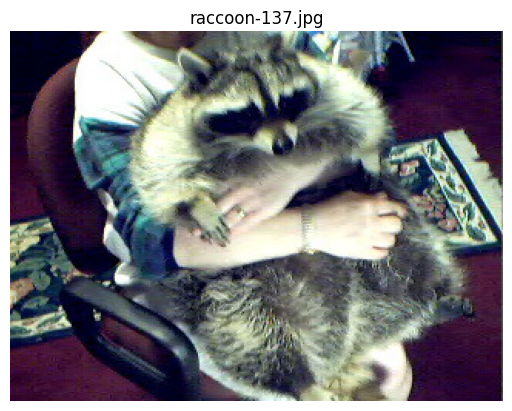

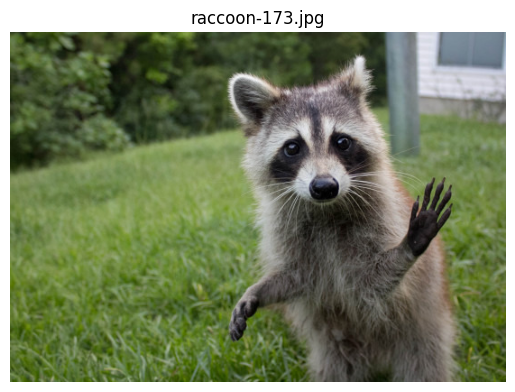

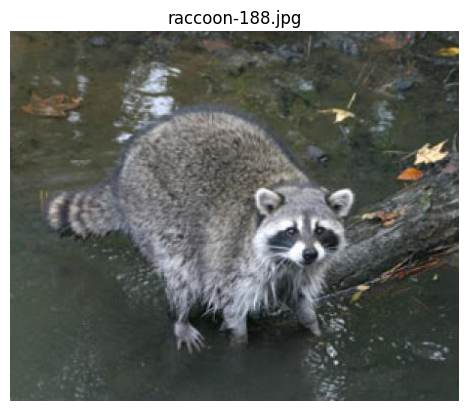

In [31]:
import cv2
import matplotlib.pyplot as plt
import os

# Define path to the raccoon images
raccoon_images_dir = "/content/raccoon_dataset/images"
raccoon_image_files = os.listdir(raccoon_images_dir)[:3]  # Display only the first 3 images

def display_sample_images(image_files, base_dir):
    for image_file in image_files:
        image_path = os.path.join(base_dir, image_file)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(image)
        plt.title(image_file)
        plt.axis('off')
        plt.show()

# Display sample images
display_sample_images(raccoon_image_files, raccoon_images_dir)

In [33]:
# Install the Mask R-CNN library
!pip install mrcnn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.5/51.5 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for mrcnn: filename=mrcnn-0.2-py3-none-any.whl size=54907 sha256=df618c979ead5af249cf17c581a1ef29396255a0cd1e8f106ff15dcd2c048071
  Stored in directory: /root/.cache/pip/wheels/f6/66/35/4956a489776a1db0ee24e0c33a9088c1b5d68eb5dc2654f0b2
Successfully built mrcnn


Train: 149 images
Test: 51 images


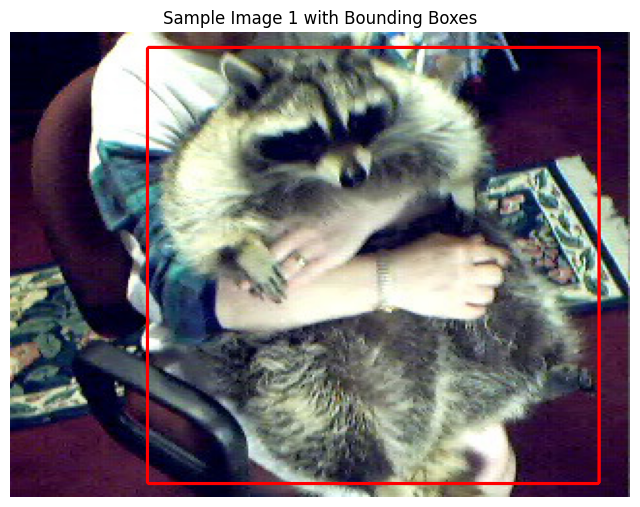

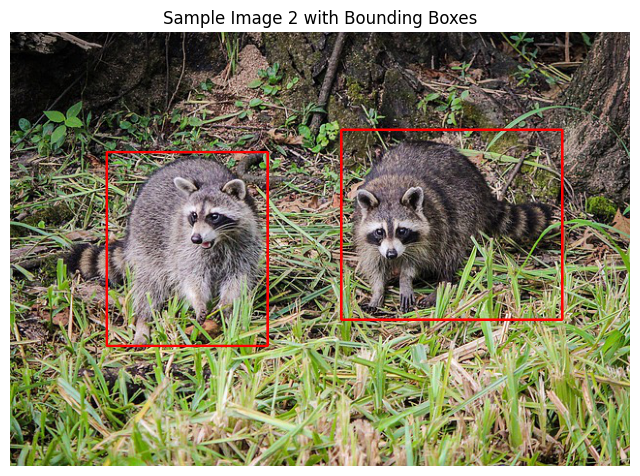

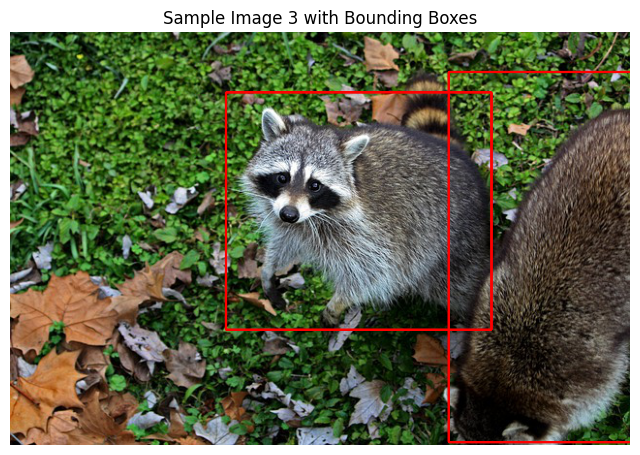

In [34]:
from os import listdir
from xml.etree import ElementTree
from numpy import zeros, asarray
from mrcnn.utils import Dataset
import matplotlib.pyplot as plt
import cv2
import os

# Class that defines and loads the raccoon dataset
class RaccoonDataset(Dataset):
    # Load the dataset definitions
    def load_dataset(self, dataset_dir, is_train=True):
        # Define one class
        self.add_class("raccoon_dataset", 1, "raccoon")
        # Define data locations
        images_dir = dataset_dir + '/images/'
        annotations_dir = dataset_dir + '/annotations/raccoon-'
        # Find all images
        for filename in listdir(images_dir):
            # Extract image ID
            image_id = filename[8:-4]
            # Skip bad images
            if image_id in ['00090']:
                continue
            # Split dataset into train and test based on image ID
            if is_train and int(image_id) >= 150:
                continue
            if not is_train and int(image_id) < 150:
                continue
            img_path = images_dir + filename
            ann_path = annotations_dir + image_id + '.xml'
            # Add to dataset
            self.add_image('raccoon_dataset', image_id=image_id, path=img_path, annotation=ann_path)

    # Extract bounding boxes from an annotation file
    def extract_boxes(self, filename):
        tree = ElementTree.parse(filename)
        root = tree.getroot()
        boxes = []
        for box in root.findall('.//bndbox'):
            xmin = int(box.find('xmin').text)
            ymin = int(box.find('ymin').text)
            xmax = int(box.find('xmax').text)
            ymax = int(box.find('ymax').text)
            coors = [xmin, ymin, xmax, ymax]
            boxes.append(coors)
        width = int(root.find('.//size/width').text)
        height = int(root.find('.//size/height').text)
        return boxes, width, height

    # Load the masks for an image
    def load_mask(self, image_id):
        info = self.image_info[image_id]
        path = info['annotation']
        boxes, w, h = self.extract_boxes(path)
        masks = zeros([h, w, len(boxes)], dtype='uint8')
        class_ids = []
        for i, box in enumerate(boxes):
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            masks[row_s:row_e, col_s:col_e, i] = 1
            class_ids.append(self.class_names.index('raccoon'))
        return masks, asarray(class_ids, dtype='int32')

    # Load an image reference
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

# Initialize and prepare the train and test datasets
train_set = RaccoonDataset()
train_set.load_dataset('/content/raccoon_dataset', is_train=True)
train_set.prepare()
print(f"Train: {len(train_set.image_ids)} images")

test_set = RaccoonDataset()
test_set.load_dataset('/content/raccoon_dataset', is_train=False)
test_set.prepare()
print(f"Test: {len(test_set.image_ids)} images")

# Display a few samples from the training set with bounding boxes
def display_samples(dataset, num_samples=3):
    for i in range(num_samples):
        image = dataset.load_image(i)
        masks, class_ids = dataset.load_mask(i)
        plt.figure(figsize=(8, 8))
        plt.imshow(image)

        for j in range(masks.shape[-1]):
            mask = masks[:, :, j]
            plt.contour(mask, colors='r', linewidths=1)

        plt.title(f"Sample Image {i + 1} with Bounding Boxes")
        plt.axis('off')
        plt.show()

# Display sample images with bounding boxes from the train set
display_samples(train_set)

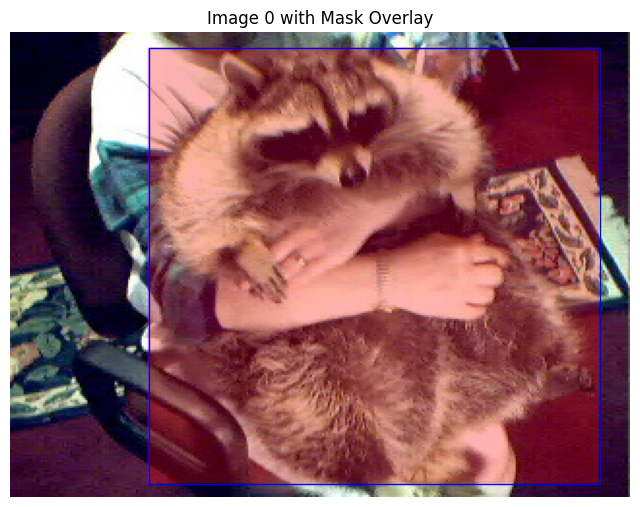

In [36]:
import matplotlib.patches as patches

def display_image_with_mask(dataset, image_id=0):
    # Load the image
    image = dataset.load_image(image_id)

    # Load the mask and class IDs
    masks, class_ids = dataset.load_mask(image_id)

    # Display the image
    plt.figure(figsize=(8, 8))
    plt.imshow(image)

    # Overlay each mask with transparency
    for i in range(masks.shape[-1]):
        mask = masks[:, :, i]

        # Apply mask with transparency
        image_with_mask = image.copy()
        image_with_mask[mask == 1] = (255, 0, 0)  # Red overlay for the mask
        plt.imshow(image_with_mask, alpha=0.3)  # Adjust alpha for transparency

        # Draw bounding box as well for reference
        box = dataset.extract_boxes(dataset.image_info[image_id]['annotation'])[0][i]
        rect = patches.Rectangle(
            (box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=1, edgecolor='blue', facecolor='none'
        )
        plt.gca().add_patch(rect)

    plt.title(f"Image {image_id} with Mask Overlay")
    plt.axis('off')
    plt.show()

# Display a sample image and its mask from the training set
display_image_with_mask(train_set, image_id=0)

# Part 3: YOLO

Annotations for image 0 saved to /content/raccoon_dataset/yolo_annotations/137.txt
YOLO Annotation Format: ['0 0.5859375 0.5020833333333333 0.728125 0.9375']


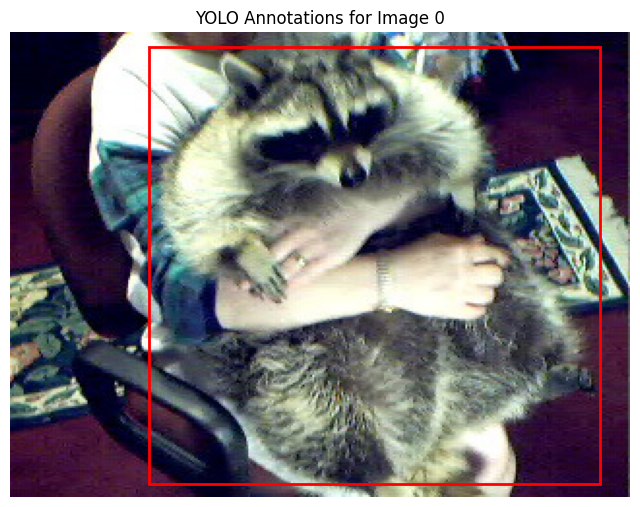

In [37]:
import os
import cv2
import matplotlib.pyplot as plt

# Define the directory where annotations will be saved
annotations_dir = "/content/raccoon_dataset/yolo_annotations"
os.makedirs(annotations_dir, exist_ok=True)

def create_yolo_annotation(dataset, image_id):
    # Get image dimensions
    image = dataset.load_image(image_id)
    h, w, _ = image.shape

    # Load bounding boxes from the dataset's XML annotations
    annotation_file = dataset.image_info[image_id]['annotation']
    boxes, img_w, img_h = dataset.extract_boxes(annotation_file)

    # Normalize and save in YOLO format
    yolo_annotations = []
    for box in boxes:
        # Calculate normalized coordinates
        x_center = ((box[0] + box[2]) / 2) / img_w
        y_center = ((box[1] + box[3]) / 2) / img_h
        width = (box[2] - box[0]) / img_w
        height = (box[3] - box[1]) / img_h

        # YOLO format: class_id x_center y_center width height
        yolo_annotations.append(f"0 {x_center} {y_center} {width} {height}")

    # Save annotations to a .txt file named after the image_id
    annotation_path = os.path.join(annotations_dir, f"{dataset.image_info[image_id]['id']}.txt")
    with open(annotation_path, 'w') as f:
        f.write("\n".join(yolo_annotations))

    return annotation_path, yolo_annotations

# Generate and display annotations for a sample image
sample_image_id = 0
annotation_path, yolo_annotations = create_yolo_annotation(train_set, sample_image_id)
print(f"Annotations for image {sample_image_id} saved to {annotation_path}")
print("YOLO Annotation Format:", yolo_annotations)

# Display the annotated image with bounding boxes
def display_annotated_image(dataset, image_id, yolo_annotations):
    image = dataset.load_image(image_id)
    h, w, _ = image.shape

    # Plot image
    plt.figure(figsize=(8, 8))
    plt.imshow(image)

    # Plot each YOLO bounding box annotation
    for annotation in yolo_annotations:
        _, x_center, y_center, box_width, box_height = map(float, annotation.split())

        # Convert normalized coordinates back to absolute coordinates for visualization
        x_min = int((x_center - box_width / 2) * w)
        y_min = int((y_center - box_height / 2) * h)
        x_max = int((x_center + box_width / 2) * w)
        y_max = int((y_center + box_height / 2) * h)

        # Draw rectangle
        plt.gca().add_patch(plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                          edgecolor='red', facecolor='none', lw=2))

    plt.title(f"YOLO Annotations for Image {image_id}")
    plt.axis('off')
    plt.show()

# Display the annotated sample image
display_annotated_image(train_set, sample_image_id, yolo_annotations)

In [45]:
!pip install ultralytics

In [60]:
from ultralytics import YOLO

# Load the YOLOv8 model
model = YOLO("yolov8s.pt")  # "yolov8s.pt" is the small model

100%|██████████| 21.5M/21.5M [00:00<00:00, 41.4MB/s]



image 1/1 /content/sample_image.jpg: 640x640 1 cat, 1 bear, 9.2ms
Speed: 2.8ms preprocess, 9.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


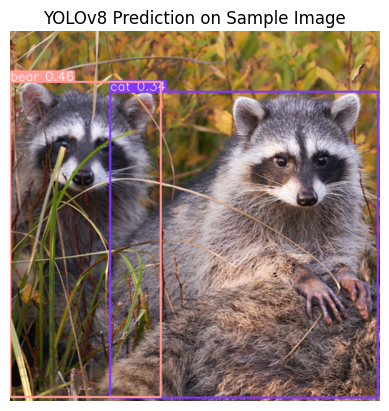

In [61]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
import cv2

# Load the YOLOv8 model with pre-trained weights
model = YOLO("yolov8s.pt")

# Set the path to your uploaded image
sample_image_path = "/content/sample_image.jpg"

# Run prediction on the sample image
results = model.predict(source=sample_image_path)

# Use the plot method to get the annotated image
annotated_image = results[0].plot()

# Display the annotated image
plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
plt.title("YOLOv8 Prediction on Sample Image")
plt.axis('off')
plt.show()

In [62]:
# Fine-tune the YOLOv8 model on coco128 for 10 epochs with a batch size of 32
model.train(data="coco128.yaml", epochs=10, batch=32)

New https://pypi.org/project/ultralytics/8.3.29 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.34 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=coco128.yaml, epochs=10, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=-1, val_period=1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=

wandb: Currently logged in as: bnajar (bnajar-university-of-san-diego). Use `wandb login --relogin` to force relogin


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /content/datasets/coco128/labels/train2017.cache... 126 images, 2 backgrounds, 0 corrupt: 100%|██████████| 128/128 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



/usr/local/lib/python3.10/dist-packages/albumentations/core/composition.py:205: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()
val: Scanning /content/datasets/coco128/labels/train2017.cache... 126 images, 2 backgrounds, 0 corrupt: 100%|██████████| 128/128 [00:00<?, ?it/s]
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b88cffa56c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
        self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000119, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train2
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/core/composition.py:205: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      7.83G       2.91      4.975      2.405        213        640: 100%|██████████| 4/4 [00:02<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.54it/s]

                   all        128        929      0.201    0.00164   0.000803    0.00026



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      7.92G      2.881      4.944      2.359        210        640: 100%|██████████| 4/4 [00:00<00:00,  6.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.39it/s]

                   all        128        929     0.0875    0.00291   0.000877   0.000227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      7.79G      2.808      5.037      2.299        237        640: 100%|██████████| 4/4 [00:00<00:00,  6.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.17it/s]

                   all        128        929   0.000794    0.00703    0.00117   0.000418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      7.79G      2.759      4.862      2.308        266        640: 100%|██████████| 4/4 [00:00<00:00,  5.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.23it/s]

                   all        128        929    0.00157     0.0087    0.00232     0.0014



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      7.87G      2.735      4.821      2.278        251        640: 100%|██████████| 4/4 [00:00<00:00,  5.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.21it/s]

                   all        128        929     0.0021    0.00936    0.00322    0.00216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      7.65G      2.726      4.748      2.252        233        640: 100%|██████████| 4/4 [00:00<00:00,  5.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.16it/s]

                   all        128        929    0.00245     0.0116    0.00434    0.00277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      7.66G      2.719      4.807      2.291        229        640: 100%|██████████| 4/4 [00:00<00:00,  6.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.27it/s]

                   all        128        929     0.0166     0.0177     0.0135    0.00724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      7.82G      2.554      4.661      2.187        258        640: 100%|██████████| 4/4 [00:00<00:00,  6.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.39it/s]

                   all        128        929     0.0168     0.0166     0.0138    0.00746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      7.75G      2.651      4.707      2.229        183        640: 100%|██████████| 4/4 [00:00<00:00,  5.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.43it/s]

                   all        128        929     0.0167      0.017     0.0143    0.00689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      7.66G      2.596      4.674      2.199        231        640: 100%|██████████| 4/4 [00:00<00:00,  6.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.41it/s]

                   all        128        929     0.0168     0.0192     0.0145    0.00693



10 epochs completed in 0.008 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 22.6MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 22.6MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics YOLOv8.1.34 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Model summary (fused): 168 layers, 11156544 parameters, 0 gradients, 28.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.69it/s]


                   all        128        929     0.0168     0.0166     0.0138    0.00747
                person        128        254    0.00363      0.535      0.148      0.064
               bicycle        128          6          0          0          0          0
                   car        128         46          0          0          0          0
            motorcycle        128          5          1        0.2        0.6        0.3
              airplane        128          6          0          0          0          0
                   bus        128          7          0          0          0          0
                 train        128          3          0          0          0          0
                 truck        128         12          0          0          0          0
                  boat        128          6          0          0          0          0
         traffic light        128         14          0          0          0          0
             stop sig

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 11, 13, 14, 15, 16, 17, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 38, 39, 40, 41, 42, 43, 44, 45, 46, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 67, 68, 69, 71, 72, 73, 74, 75, 76, 77, 79])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7b86b6bb3ca0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,

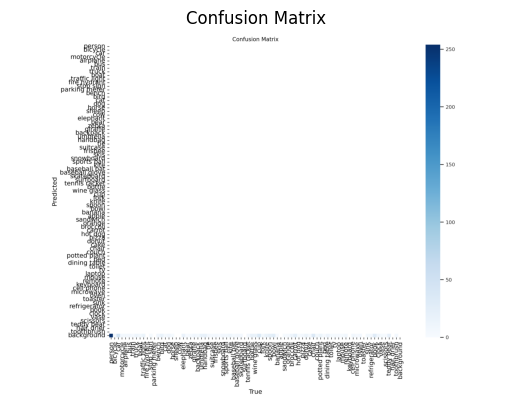

In [63]:
import matplotlib.pyplot as plt

# Path to the confusion matrix image
confusion_matrix_img = plt.imread(f"{HOME}/runs/detect/train/confusion_matrix.png")
plt.imshow(confusion_matrix_img)
plt.title("Confusion Matrix")
plt.axis('off')
plt.show()

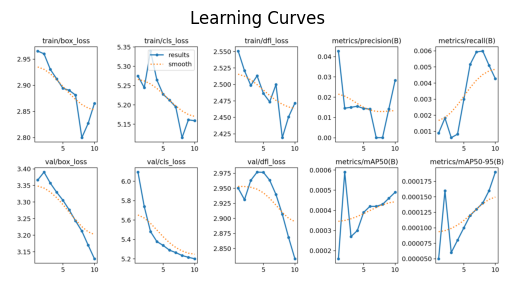

In [64]:
# Path to the learning curves image
results_img = plt.imread(f"{HOME}/runs/detect/train/results.png")
plt.imshow(results_img)
plt.title("Learning Curves")
plt.axis('off')
plt.show()

The learning curves suggest that the model is training well. Losses are decreasing for both training and validation, indicating effective learning without significant overfitting. Precision, recall, and mAP metrics are showing improvement, which confirms that the model is getting better at identifying and localizing objects accurately.